In [20]:
import os
if os.path.exists("/content/Captcha_iitkgp") is not True:
  !git clone "https://github.com/Sandeep-1507/Captcha_iitkgp"

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.12.0
REPLICAS:  1


In [23]:
data_dir=Path("Captcha_iitkgp/Data/trainset")
images=sorted(list(map(str,list(data_dir.glob("*.jpeg")))))



display(images[0])

labels=[img.split(os.path.sep)[-1].split(".jpeg")[0] for img in images]

# print(labels)

characters=set(char for label in labels for char in label)
print(characters)
characters=sorted(list(characters))


# print(len(characters))
# images=[clear_img(img) for img in images]

'/content/Captcha_iitkgp/Data/trainset/222374.jpeg'

{'Y', 'x', '6', '8', 'j', 'G', 'w', '3', 'C', 'D', 'V', 'U', 's', 'u', '2', 'T', 'R', 'K', 'c', 'L', '4', '7', 'P', 'H', 'S', '9', 'A', 'X', 'y', 'N', 'B', 'Z', 'M', 'W', '5', 'F', 'E', 'J'}


In [24]:
batch_size = 24
sample=Image.open(images[0])
image_width,image_height=(198,50)
print(image_width,image_height)

downsample_factor=2

198 50


In [25]:
max_length = max([len(label) for label in labels])
display(max_length)

6

In [26]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup
char_to_num=layers.StringLookup(vocabulary=list(characters),mask_token=None)

num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [27]:
def encode_single_sample(img_path,label):
    img=tf.io.read_file(img_path)
    img=tf.io.decode_jpeg(img,channels=1)
    img=tf.image.convert_image_dtype(img,tf.float32)
#     img=tf.transpose(img)
#     img=tf.image.resize(img,[image_width,image_height])
#     img=tf.image.resize(img,[sample])
#     img = tf.transpose(img, perm=[1, 0, 2]) #????
    label=char_to_num(tf.strings.unicode_split(label,input_encoding="UTF-8"))

    return {"image": img, "label": label}


In [28]:
print(encode_single_sample(images[0],labels[0]))

{'image': <tf.Tensor: shape=(50, 198, 1), dtype=float32, numpy=
array([[[0.8352942 ],
        [0.8313726 ],
        [0.8313726 ],
        ...,
        [0.6745098 ],
        [0.6745098 ],
        [0.67058825]],

       [[0.8235295 ],
        [0.8235295 ],
        [0.8196079 ],
        ...,
        [0.65882355],
        [0.65882355],
        [0.654902  ]],

       [[0.8431373 ],
        [0.8431373 ],
        [0.8431373 ],
        ...,
        [0.654902  ],
        [0.6509804 ],
        [0.6509804 ]],

       ...,

       [[0.8235295 ],
        [0.8235295 ],
        [0.8235295 ],
        ...,
        [0.654902  ],
        [0.6509804 ],
        [0.6509804 ]],

       [[0.8235295 ],
        [0.8196079 ],
        [0.8196079 ],
        ...,
        [0.6509804 ],
        [0.64705884],
        [0.64705884]],

       [[0.8235295 ],
        [0.8196079 ],
        [0.8196079 ],
        ...,
        [0.6509804 ],
        [0.64705884],
        [0.64705884]]], dtype=float32)>, 'label': <tf.Tensor: sha

In [29]:
def split_data(images,labels,train_size=0.9,shuffle=True):
    size=len(images)
    indices=np.arange(size)
    if(shuffle):
        np.random.shuffle(indices)
    train_samples= int(size*train_size)

    x_train,y_train=images[indices[:train_samples]],labels[indices[:train_samples]]
    x_val,y_val=images[indices[train_samples:]],labels[indices[train_samples:]]

    return x_train,y_train,x_val,y_val

In [30]:
x_train, y_train, x_val, y_val = split_data(np.array(images), np.array(labels))

In [31]:
x_train.size

23539

In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = (validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))


In [33]:
# display(train_dataset[0])

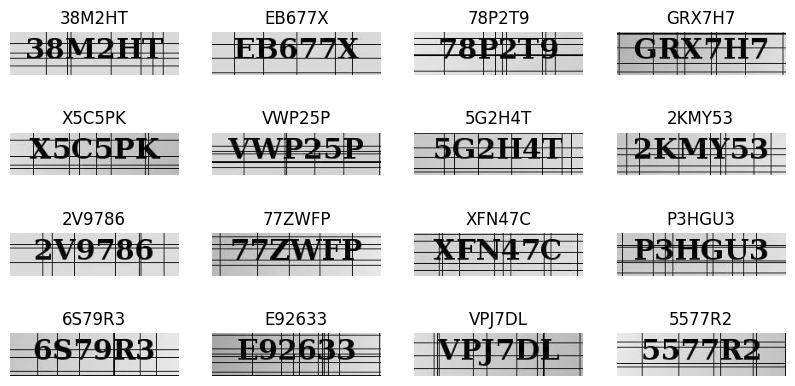

In [34]:
_,ax=plt.subplots(4,4,figsize=(10,5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img=(images[i]*255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i//4, i % 4].imshow(img[:, :, 0], cmap="gray",aspect="1")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

38M2HT
(50, 198, 1)


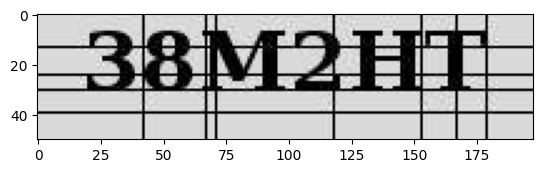

In [35]:
#single sample
image=batch["image"][0]
label=batch["label"][0]
img=(image*255).numpy().astype("uint8")
labl= tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
image = Image.fromarray(img.squeeze())
plt.imshow(image,cmap="gray",aspect="1")
print(labl)
print(img.shape)

In [36]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)


        return y_pred

In [37]:
def build_model():

    input_img = layers.Input(
        shape=(image_height,image_width, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")


    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)


    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)


    new_shape = ((image_height // 4), (image_width // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)


    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)


    output = CTCLayer(name="ctc_loss")(labels, x)


    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )

    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt)
    return model



model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 50, 198, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 198, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 25, 99, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 25, 99, 64)   18496       ['pool1[0][0]']       

In [38]:
epochs = 100
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)


history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
981/981 [==============================] - 45s 37ms/step - loss: 19.3423 - val_loss: 14.5031
Epoch 2/100
981/981 [==============================] - 33s 34ms/step - loss: 12.1528 - val_loss: 7.8477
Epoch 3/100
981/981 [==============================] - 35s 36ms/step - loss: 7.9709 - val_loss: 4.7025
Epoch 4/100
981/981 [==============================] - 33s 34ms/step - loss: 5.7573 - val_loss: 3.2849
Epoch 5/100
981/981 [==============================] - 35s 35ms/step - loss: 4.5301 - val_loss: 2.6411
Epoch 6/100
981/981 [==============================] - 34s 35ms/step - loss: 3.8026 - val_loss: 2.1792
Epoch 7/100
981/981 [==============================] - 36s 37ms/step - loss: 3.2631 - val_loss: 1.8043
Epoch 8/100
981/981 [==============================] - 39s 40ms/step - loss: 2.8133 - val_loss: 1.5223
Epoch 9/100
981/981 [==============================] - 34s 35ms/step - loss: 2.4893 - val_loss: 1.3221
Epoch 10/100
981/981 [==============================] - 35s 35ms/step 

In [39]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 50, 198, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 50, 198, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 25, 99, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 25, 99, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 49, 64)        0         
                                                                 
 reshape (Reshape)           (None, 12, 3136)          0         
                                                                 
 dense1 (Dense)              (None, 12, 64)            200768

In [40]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]

    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

1/1 [==============================] - 0s 41ms/step
accuracy of prediction = 100.0
1/1 [==============================] - 0s 37ms/step
accuracy of prediction = 95.83333333333334
1/1 [==============================] - 0s 26ms/step
accuracy of prediction = 95.83333333333334
1/1 [==============================] - 0s 23ms/step
accuracy of prediction = 100.0


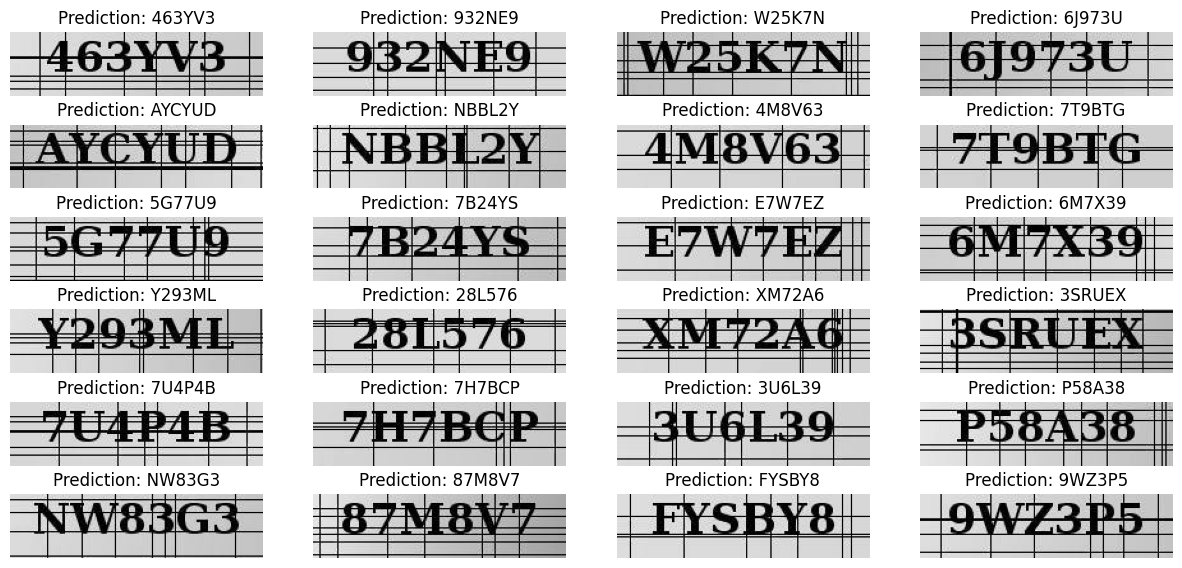

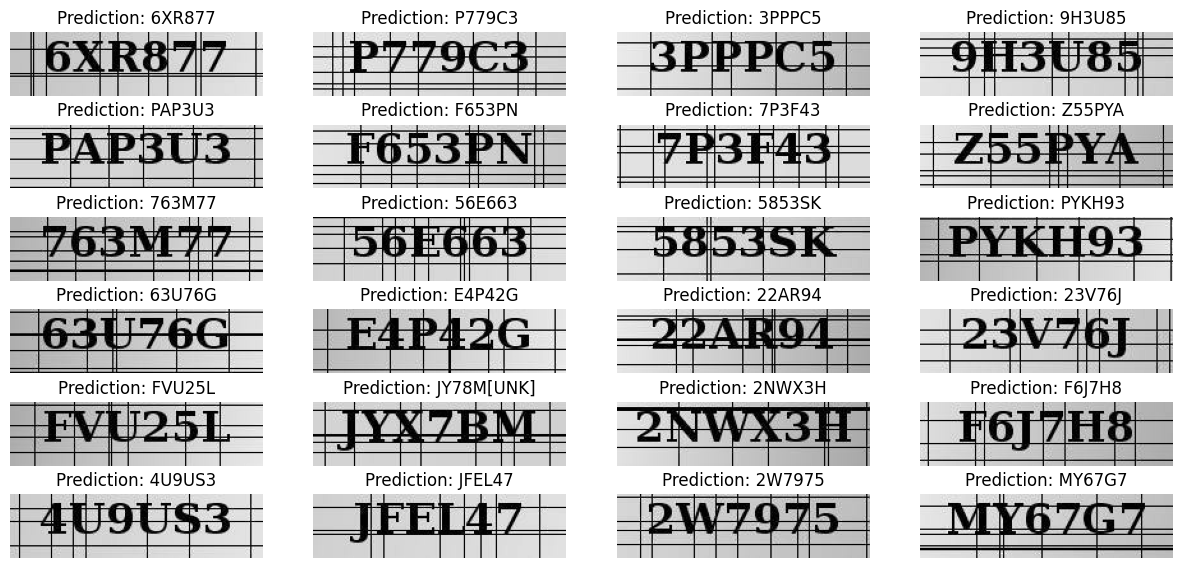

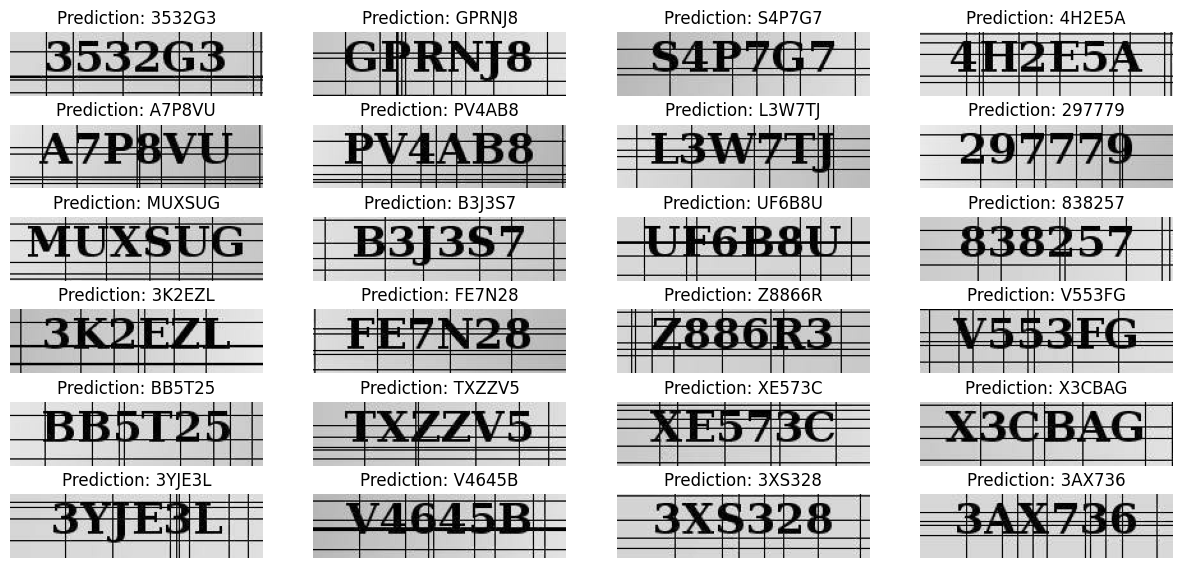

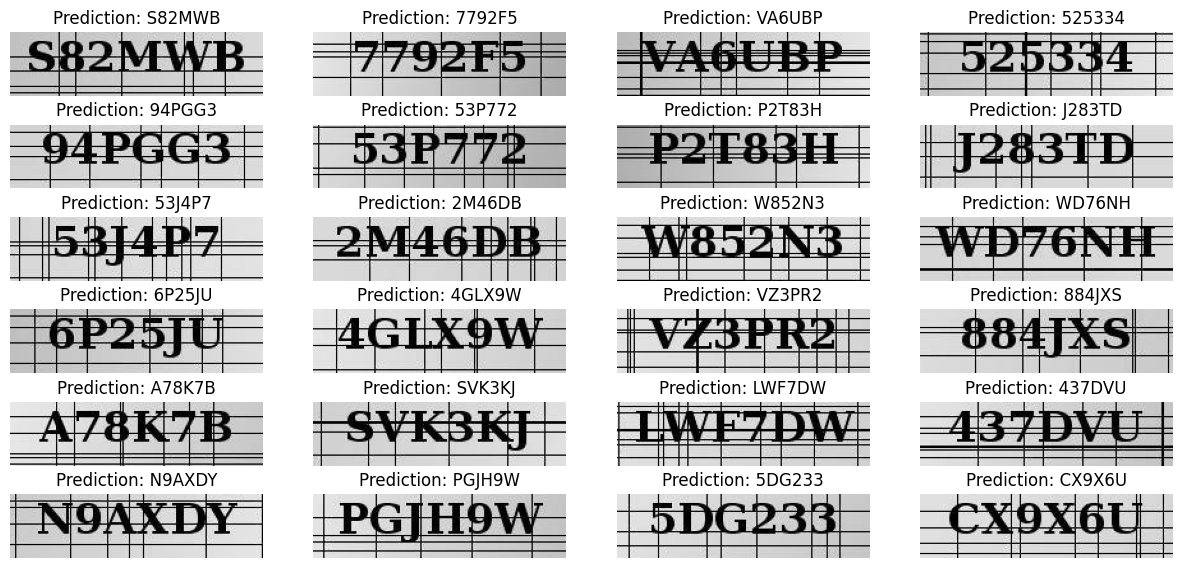

In [56]:
for batch in validation_dataset.take(4):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)


    from sklearn.metrics import accuracy_score

    accuracy=accuracy_score(pred_texts,orig_texts)*100
    print("accuracy of prediction = {}".format(accuracy))



    _, ax = plt.subplots(6, 4, figsize=(15, 7))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        # img = img
        title = f"Prediction: {pred_texts[i]}"
        if i < 24:
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
plt.show()

In [42]:
# model.save("/content/Captcha_iitkgp/model")

In [43]:
# !zip -r file.zip /content/Captcha_iitkgp/model

In [44]:
# from IPython.display import FileLink
# FileLink(r'file.zip')


In [45]:
# len(x_val)